In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Configure paths
path = Path("/Users/william/Projects/PETracer_Paper/lineage_tracer_simulation")
results_path = path / "results"
plots_path = path / "plots"
module_path = path.parent
sys.path.append(str(module_path))

# Load source
plt.style.use(module_path / 'plot.mplstyle')

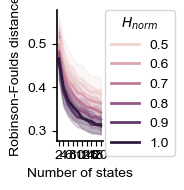

In [2]:
# Load results
state_dist_results = pd.read_csv(
    results_path / "state_distribution_simulation.tsv",sep="\t")

plt.figure(figsize=(2,2))
sns.lineplot(data=state_dist_results, x="states", y="rf", 
    hue="entropy")
plt.xlabel("Number of states")
plt.ylabel("Robinson-Foulds distance")
plt.xticks(state_dist_results['states'].unique());
plt.legend(title="$H_{norm}$",bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()

In [3]:
def identify_best_solver(results,group,metric = "rf",max = False):
    results = results.copy()
    average_value = results.groupby(group + ['solver'], as_index=False)[metric].mean()
    if max:
        best_solver_idx = average_value.groupby(group)[metric].idxmax()
    else:
        best_solver_idx = average_value.groupby(group)[metric].idxmin()
    average_value['best_solver'] = average_value.index.isin(best_solver_idx)
    results = results.merge(average_value[group + ['solver', 'best_solver']], 
                            on=group + ['solver'], 
                            how='left')
    return results["best_solver"].values

In [29]:
solvers = {"nj":"Neighbor Joining","upgma":"UPGMA","hybrid":"Vanilla Hybrid"}
def plot_heatmap_by_solver(results,x,xlabel,y,ylabel,metric,metric_label,
                           cmap = "viridis", log = False):
    # Get min and max RF values
    metric_min = results[metric].min()
    metric_max = results[metric].max()

    #annotate best solver
    results['best'] = identify_best_solver(results,[y,x],max = False)

    # Create a subplot for each solver
    fig, axes = plt.subplots(1,3, figsize=(6, 2))
    axes = axes.flatten() 

    for i, solver in enumerate(solvers.keys()):
        ax = axes[i]

        # Create a pivot table for the heatmap
        metric_mat = results[results["solver"] == solver].groupby([y,x])[metric].mean().unstack()

        # Plot the heatmap
        sns.heatmap(metric_mat, ax=ax, cbar_kws={'label': metric_label}, cmap=cmap, vmin=metric_min, vmax=metric_max)

        # Annotate each cell
        for j, j_value in enumerate(metric_mat.index):
            for i, i_value in enumerate(metric_mat.columns):
                value = metric_mat.loc[j_value, i_value]
                # Check if this solver is the best for the current combination of entropy and state
                is_best = results[(results[x] == i_value) & (results[y] == j_value) & (results['best'])]['solver'].iloc[0] == solver
                weight = 'bold' if is_best else 'normal'
                ax.text(i + 0.5, j + 0.5, f'{value:.2f}', ha='center', va='center', fontsize=8, fontweight = weight)

        ax.set_title(solvers[solver])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [24]:
solvers = {"nj":"Neighbor Joining",
            "upgma":"UPGMA",
            "hybrid":"Cassiopeia Hybrid"}

def heatmap_by_solver(results, x, xlabel, y, ylabel, metric, metric_label, cmap="viridis", log=False):
    # Get min and max RF values
    metric_min = results[metric].min()
    metric_max = results[metric].max()

    # Annotate best solver
    results['best'] = identify_best_solver(results, [y, x], max=False)

    # Create a subplot for each solver
    fig, axes = plt.subplots(1, 3, figsize=(6, 2.4), sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i, solver in enumerate(solvers.keys()):
        ax = axes[i]

        # Create a pivot table for the heatmap
        metric_mat = results[results["solver"] == solver].pivot_table(index=y, columns=x, values=metric, aggfunc='mean')

        # Plot the heatmap
        sns.heatmap(metric_mat, ax=ax, cbar=i == 0, cbar_ax=None if i else cbar_ax, cmap=cmap, vmin=metric_min, vmax=metric_max)

        # Annotate each cell
        for j, j_value in enumerate(metric_mat.index):
            for k, k_value in enumerate(metric_mat.columns):
                value = metric_mat.loc[j_value, k_value]
                # Check if this solver is the best for the current combination of entropy and state
                is_best = results[(results[x] == k_value) & (results[y] == j_value) & (results['best'])]['solver'].iloc[0] == solver
                weight = 'bold' if is_best else 'normal'
                ax.text(k + 0.5, j + 0.5, f'{value:.2f}', ha='center', va='center', fontsize=7.5, fontweight = weight)

        ax.set_title(solvers[solver])
        ax.set_xlabel(xlabel if i == 1 else "")  # Only middle plot gets the xlabel
        if i == 0:
            ax.set_ylabel(ylabel)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        else:
            ax.set_ylabel("")  # Remove y-label for non-first subplots
            

    plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make room for the colorbar
    plt.show()

/var/folders/qd/nvzjj6dd3bx9d0pqsk7m4tr80000gn/T/ipykernel_8321/1917751409.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make room for the colorbar


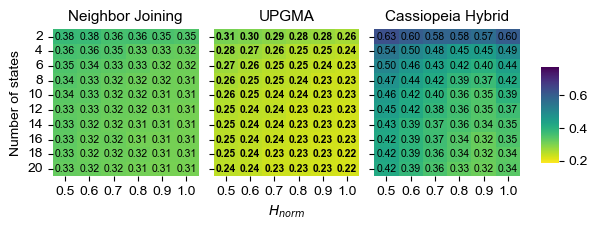

In [25]:
heatmap_by_solver(state_dist_results,"entropy","$H_{norm}$",
                       "states","Number of states","rf","Mean Robinson-Foulds distance",
                       cmap = "viridis_r")

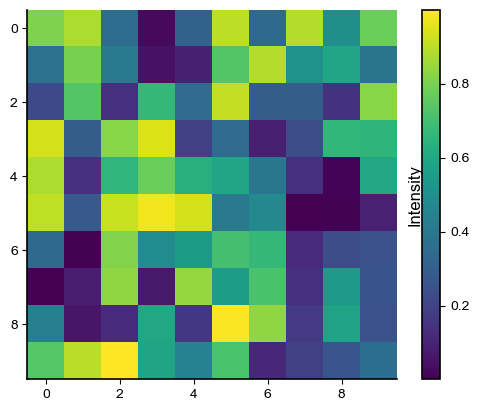

In [21]:
# Create some data to plot
data = np.random.rand(10,10)

# Create a figure and a subplot
fig, ax = plt.subplots()

# Display the data
cax = ax.imshow(data, interpolation='nearest')

# Create a ScalarMappable and initialize with the colormap and the normalization
norm = Normalize(vmin=data.min(), vmax=data.max())
sm = ScalarMappable(norm=norm, cmap=cax.cmap)

# Add the colorbar using the ScalarMappable
cb = fig.colorbar(sm, ax=ax)

# Add a label to the colorbar
cb.set_label('Intensity', fontsize=12,labelpad=-45)

plt.show()